In [134]:
import sys
sys.path.append("/Users/irisstone/Google Drive (istone@princeton.edu)/Princeton/Research/Striatum Towers Task/code/glmhmm")
import matplotlib.pyplot as plt
import numpy as np
from glmhmm import hmm
from glmhmm.utils import permute_states
from glmhmm.visualize import plot_transitions

In [137]:
# set the parameters of the GLM
N = 10000 # number of data/time points
K = 3 # number of latent states
C = 2 # number of observation classes

In [138]:
# make a HMM with these parameters and set distribution type
true_HMM = hmm.HMM(N,0,C,K)
A_true,phi_true,pi_true = true_HMM.generate_params()
true_y,true_z = true_HMM.generate_data(A_true,phi_true)
#true_ll = true_GLM.neglogli(true_x,true_w,true_y) * -1

In [139]:
# fit model
inits = 5
lls_all = np.zeros((inits,250))
A_all = np.zeros((inits,K,K))
phi_all = np.zeros((inits,K,C))
for i in range(inits):
    A_init,phi_init,pi_init = true_HMM.generate_params()
    lls_all[i,:],A_all[i,:,:],phi_all[i,:,:],pi0 = true_HMM.fit(true_y,A_init,phi_init)
    print('initialization %s complete' %(i+1))
# fit_ll = true_GLM.ll
# fit_ll = true_GLM.neglogli(true_x,w,true_y) * -1

initialization 1 complete
initialization 2 complete
initialization 3 complete
initialization 4 complete
initialization 5 complete


Text(0, 0.5, 'loglikelihood')

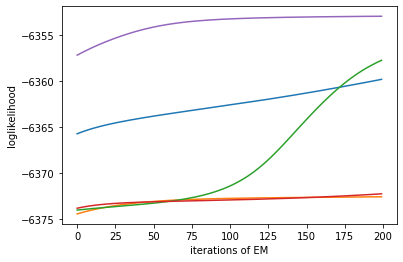

In [144]:
plt.plot(lls_all.T[50:])
plt.xlabel('iterations of EM')
plt.ylabel('loglikelihood')

In [149]:
bestix = find_best_fit(lls_all)
A_permuted, order = permute_states(A_all[bestix])
A_true_permuted, order = permute_states(A_true)

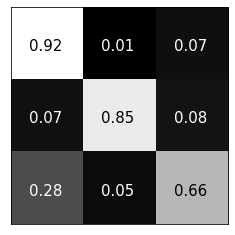

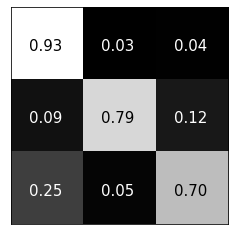

In [150]:
fig = plot_transitions(A_true_permuted)
fig = plot_transitions(A_permuted)

In [151]:
true_ll,_,_ = true_HMM.forwardPass(true_y,A_true,phi_true,pi0=None)
fit_ll,_,_ = true_HMM.forwardPass(true_y,A_all[bestix],phi_all[bestix])

# compare loglikelihoods
print('True LL: %f' %(true_ll))
print('Fit LL: %f' %(fit_ll))

True LL: -6355.680997
Fit LL: -6352.951578
